#  Physics Informed Neural Network

## Genesis Quiles-Galarza

We're going to use a neural network to approximate the solution $u(x)$ of the Helmholtz equation:
$$
\nabla^2 u(x) - \lambda u(x) = f(x), x \in [-1,1], \lambda = 1
$$
where $f(x) = -(\pi^2 + \lambda)sin(\pi x)$. To do so, generate a set of $N_f$ training data on $f(x)$ using a  Latin Hypercube strategy, and a set of $N_u = 2$ training data on $u(x)$ corresponding fo the known boundary conditions, $u(-1)=0$, and $u(1)=0$. Then, we'll train a _physics informed neural network_ with two hidden layers, 50 neurons per layer, and a hyperbolic tangent activation function to approximate $u(x)$, by minimizing the compostite mean square error loss:
$$
MSE = MSE_u + MSE_f := \frac {1}{N_u}\sum^{N_u}_{i=1}[\nabla^2 u(x_i) - \lambda u(x_i)-f_i]^2
$$
where $u_i$, $f_i$, correspond to the training data on $u(x)$ and $f(x)$, respectively, and $u(x_i)$ corresponds to the neural network output at those locations $x_i$. Use your favorite automatic differentiation package to compute $\nabla^2 u(x_i)$. Plot the $\mathbb{L}2$ error in approximating $u(x)$ as the number of training points $N_f$ is increased. The exact solution for this problem is $u(x) = sin(\pi x)$.


In [25]:
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
import pylab as p
import scipy
from scipy import integrate
from pyDOE import *
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import cv2
import os
from PIL import Image

In [2]:
class PhysNeuralNetwork(nn.Module): # Define the physical NN as a torch module
    def __init__(self):
        super(PhysNeuralNetwork,self).__init__()
        self.layer1 = nn.Linear(1,50)
        self.layer2 = nn.Linear(50,50)
        self.out = nn.Linear(50,1)
        
    def forward(self,x): #forward pass
        u_pred = self.layer1(x)
        u_pred = torch.tanh(u_pred)
        u_pred = self.layer2(u_pred)
        u_pred = torch.tanh(u_pred)
        u_pred = self.out(u_pred)
        return u_pred
    
class Phys_NN:
    def __init__(self):
        self.net = PhysNeuralNetwork()
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        self.loss_track = [] #keeps track of the loss over iterations
        #BCs are always the same, keep them as variables:
        xu = torch.zeros(2, 1).type(torch.FloatTensor)
        xu[0, 0] = -1.0
        xu[1, 0] = 1.0
        self.xu = xu
        self.fu = torch.zeros(2, 1).type(torch.FloatTensor)
    
    def get_CMSE_Loss(self,x,fx):
        # Calculate the Composite mean square error loss
        x.requires_grad_(True)
        u_pred = self.net(self.xu)
        f_pred = self.net(x)
        gradf = f_pred.sum()
        gradf = torch.autograd.grad(gradf, x, create_graph=True)[0]
        grad2f = gradf.sum()
        grad2f = torch.autograd.grad(grad2f, x, create_graph=True)[0]
        MSEu = torch.mean((u_pred - self.fu)**2)
        MSEf = torch.mean((grad2f - f_pred - fx)**2)
        loss =MSEu + MSEf
        return loss
    
    def train(self,x, fx):
        # optimize to get weights in each hidden layer
        #self.glorot_init() #Figure this out later
        t = time.time()
        maxiter= 5000
        for i in range(maxiter):
            err = self.get_CMSE_Loss(x,fx)
            self.loss_track.append(err)
            self.optimizer.zero_grad()
            err.backward(retain_graph=True)
            self.optimizer.step()
        elapsed = time.time() - t
        elapsed = np.around(elapsed,2)
        print('Completed neural network training. Time elapsed: '+str(elapsed) + 's')
        #return H,w0,b0,w1,b1,w2,b2
        
    def predictTest(self,x_test,u_test):
        pyx = self.net(x_test)
        n = x_test.shape[0]
        #calculate L2 norm
        accuracy = torch.norm(pyx-u_test)/n
        accuracy = accuracy.data.numpy()
        pyx = pyx.data.numpy()
        return accuracy, pyx
    

In [3]:
def get_data1(Nf):
    x = lhs(1,Nf)
    x = x*2-1
    fx = -(np.pi**2 + 1)*np.sin(np.pi*x)
    x = torch.from_numpy(x).type(torch.FloatTensor)
    fx = torch.from_numpy(fx).type(torch.FloatTensor)
    return x, fx

def nn_model1(Nf):
    x, fx = get_data1(Nf)
    # create instance of Neural Network class
    nnmod1 = Phys_NN()
    # Train the model
    nnmod1.train(x, fx)
    ux = torch.sin(np.pi*x)
    # Get the accuracy of the model
    accuracy, f_pred = nnmod1.predictTest(x,ux)
    x = x.detach().numpy()
    ux = ux.detach().numpy()
    #plot the test data versus the prediction (to test that it worked)
    #fig,ax = plt.subplots(figsize=(8,6))
    #ax.scatter(x,ux,label='test')
    #ax.scatter(x,f_pred,label = 'prediction')
    #ax.set_xlabel('x')
    #ax.set_title("Prediction using N = {} training points".format(Nf))
    #ax.legend()
    #plt.show()
    print("The L2 norm using",Nf,"observations is:", accuracy)
    return accuracy

def make_L2_plot(N_list,L2):
    fig,ax = plt.subplots(figsize=(8,6))
    fig1 = ax.plot(N_list,L2)
    ax.set_xlabel('$N_f$')
    ax.set_ylabel('L2 Norm')
    plt.show()
    

Beginning training with 10 data points...
Completed neural network training. Time elapsed: 12.17s
The L2 norm using 10 observations is: 0.010595823
Training with N= 10 data points completed.
Beginning training with 50 data points...
Completed neural network training. Time elapsed: 15.01s
The L2 norm using 50 observations is: 0.00012666722
Training with N= 50 data points completed.
Beginning training with 100 data points...
Completed neural network training. Time elapsed: 17.35s
The L2 norm using 100 observations is: 6.421647e-05
Training with N= 100 data points completed.
Beginning training with 200 data points...
Completed neural network training. Time elapsed: 20.34s
The L2 norm using 200 observations is: 4.8254486e-05
Training with N= 200 data points completed.
Beginning training with 500 data points...
Completed neural network training. Time elapsed: 29.84s
The L2 norm using 500 observations is: 3.5313627e-05
Training with N= 500 data points completed.
Beginning training with 1000 

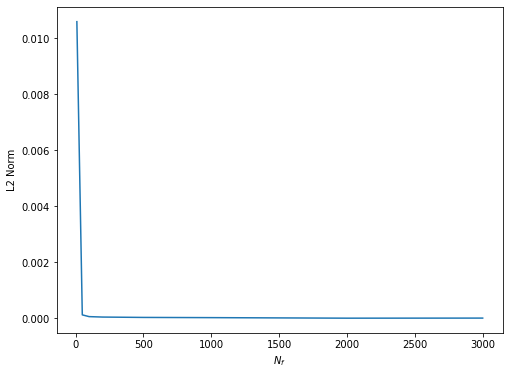

In [4]:
N_list = [10,50,100, 200, 500, 1000, 2000, 3000]
err_list = []

for n in N_list:
    print('Beginning training with',n,'data points...')
    acc = nn_model1(n)
    err_list.append(acc)
    print('Training with N=',n,'data points completed.')
    
make_L2_plot(N_list,err_list)